In [183]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local     # Local because of non-uniformity on image
from PIL import Image

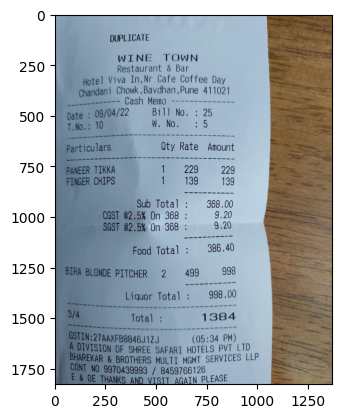

In [185]:
# # Sample file out of the dataset

# Load the image
img = cv2.imread(r"C:\Users\tprat\Desktop\Project\OCR\Assignment-20230401T120858Z-001\Assignment\image10.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display binary image
plt.imshow(rgb_img)
plt.show()


# Scale the image
scale_percent = 200
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# Increase contrast
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast_img = clahe.apply(gray)

# Binarize image
threshold_value = 100
binary_img = cv2.threshold(contrast_img, threshold_value, 255, cv2.THRESH_BINARY)[1]

# Noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

# Skew correction
coords = np.column_stack(np.where(closing > 0))
angle = cv2.minAreaRect(coords)[-1]
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle
(h, w) = closing.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(closing, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# Save skew corrected image as PNG
cv2.imwrite("Binarized.png", binary_img)

# # Display the results

cv2.imshow("Binarized", binary_img)

cv2.waitKey(0)
cv2.destroyAllWindows()



# Receipt Contour Detection
to find receipt contour, standart edge detection preprocessing is applied:

In [186]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [187]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [188]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [189]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

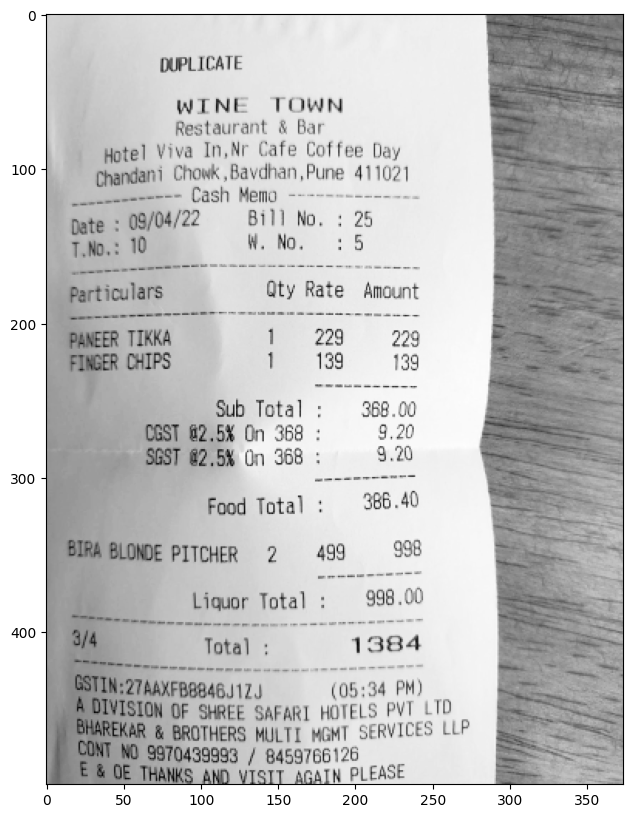

In [190]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

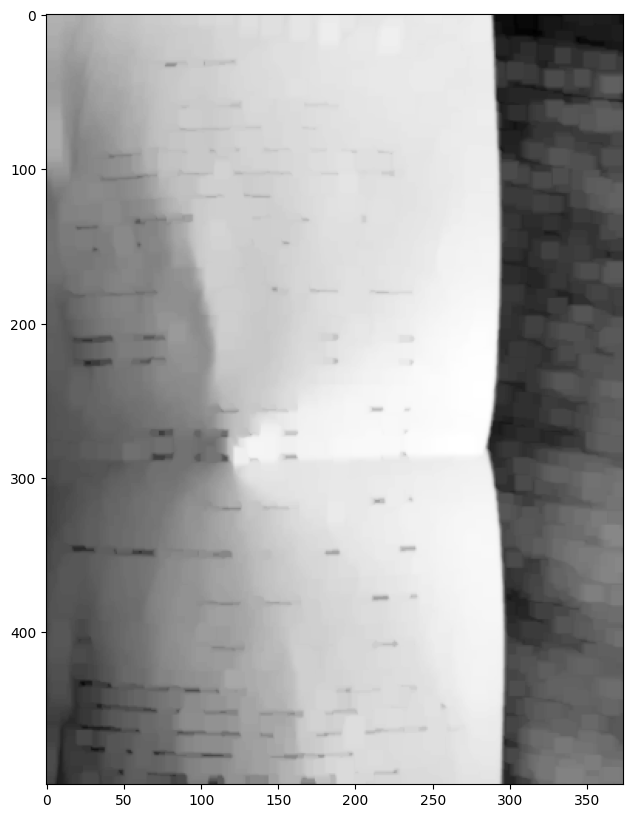

In [191]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# plot_gray(blurred)

# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

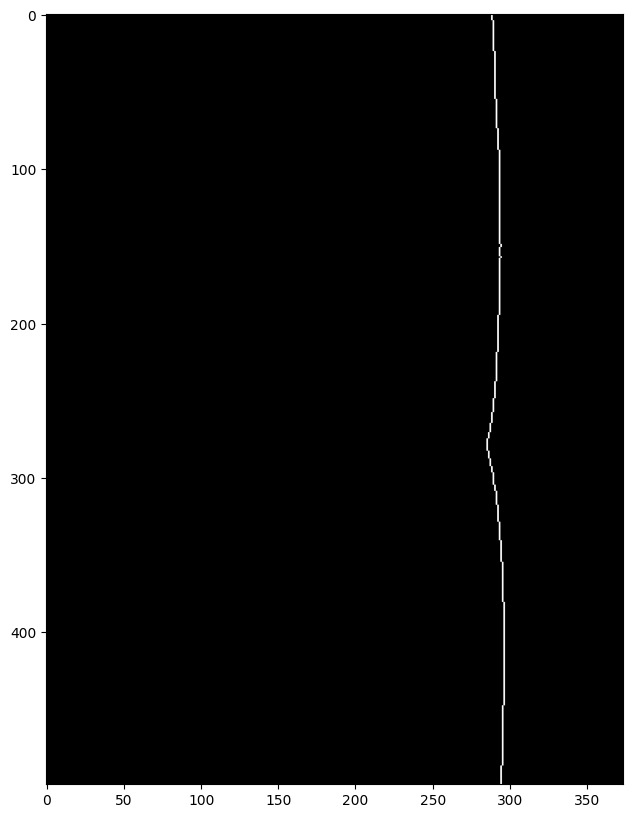

In [192]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

In [193]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
# plot_rgb(image_with_contours)

# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
# plot_rgb(image_with_largest_contours)

In [194]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [195]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
    
    return None

# Cropping if required and perspective restoration

 `cv2.warpPerspective` to restore perspective of the receipt. 
* convert contour into a rectangle-like coordinate
* use rectangle points to calculate destination points of the "scanned" view
* feed destination points into `cv2.getPerspectiveTransform` to calculate transformation matrix
* and finally use `cv2.warpPerspective` to restore the perspective!

In [196]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [197]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

Now we can make use of helper methods defined to get a perspective version of the receipt:

In [198]:
if get_receipt_contour(largest_contours):
    receipt_contour = get_receipt_contour(largest_contours)
    image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
    plot_rgb(image_with_receipt_contour)
    scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
    plt.figure(figsize=(16,10))
    plt.imshow(scanned)

else:
    scanned = binary_img.copy()
    # plt.imshow(scanned)


Now the final part - obtain black and white scanner effect with the color transformation:

In [199]:
def bw_scanner(image):
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(image, 21, offset = 5, method = "gaussian")
    return (image > T).astype("uint8") * 255

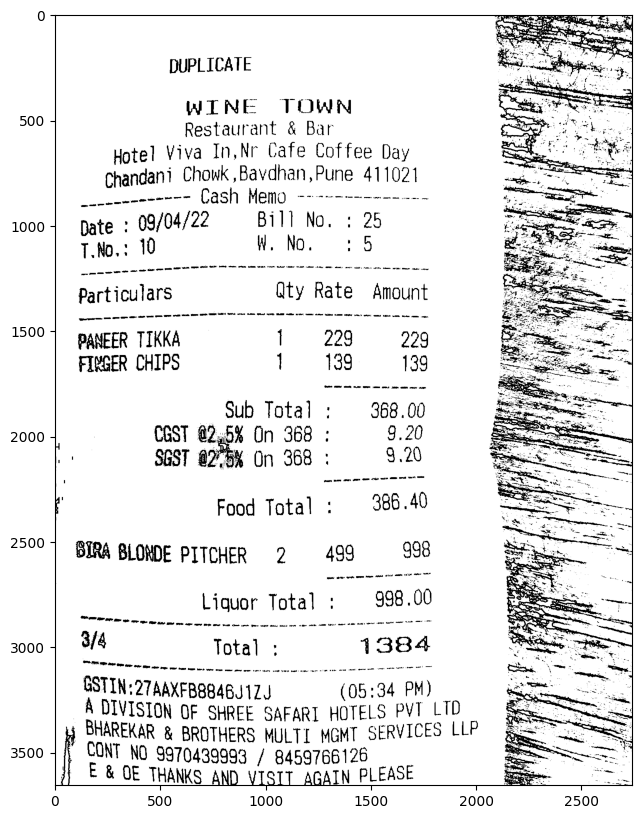

In [200]:
result = bw_scanner(scanned)
plot_gray(result)

In [201]:
output = Image.fromarray(result)
output.save('result.png')

We are done with the first part of the *Receipt OCR with OpenCV* series! 

Let's recap:
* At first, we have applied OpenCV preprocessing to get rid of noise and detect contours
* Next, we used heuristics and contour approximation methods to find contour of the receipt
* Finally, we used perspective transformation to obtain top-down view of the receipt

The transformed image is ready for Optical Character Recognition (OCR) which is covered in the [next notebook of the series](https://www.kaggle.com/dmitryyemelyanov/receipt-ocr-part-2-text-recognition-by-tesseract).

In [223]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

Defining helper methods:

In [224]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


We will use a scanned version of the receipt, which result.png

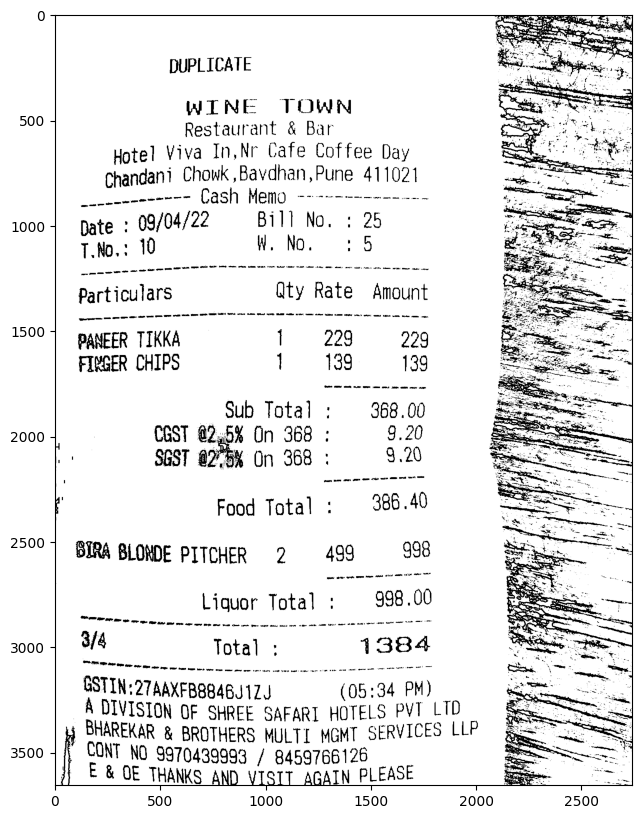

In [225]:
file_name = r"C:\Users\tprat\Desktop\Project\OCR\result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

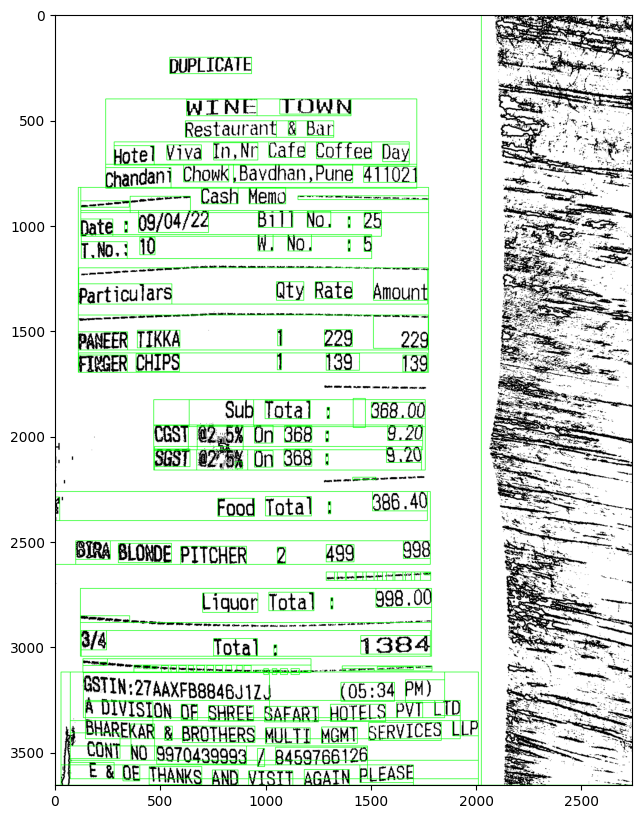

In [226]:

# Text box detection
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'  # your path may be different

d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)

In [227]:
# Text recognition
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

DUPLICATE

WINE TOWN
Restaurant & Bar
Hotel Viva In,Nr Cafe Coffee Day
chandani Chowk ,Bavdhan,Pune 411021

— ween Cash Memo -----~---------
Date : 09/04/22 Bill No. : 25
T.No.: 10 W. No. 3 8
Particulars (ity Rate mount
PANEER TIKKA 1 229 999
FIVGER CHIPS 1 139. 139

Sub Total : — 368.00
CGST @2u54 On 368 : 9,20
SGST @275% On 368 : 9.20

| .

: Food Total : «386.40
BYRA BLONDE PITCHER 2 499 998

eves ees sae, Me Pons Na hid amin HTL abo A

__ Liquor Total : 998.00
3/4 Total : 1384

. 7
~ a a ee EE ieee Som tate Won mie Em eed eee Lael ioe ae teed eee La
'

ee ne ae

BSTIN:27AAXFBBB4B17, (05:34 PM)
BRAREKin OF SHREE SAFARI HOTELS PVT LTD
CONT “ & BROTHERS MULTI MGMT SERVICES LLP
ER 9970439993 / 8459766126

, QE THANKS AND VTSTT AGATN PLEASE




# Extract info on Invoice No. and grand total

In [228]:
def find_amounts(text):
    decimal_numbers = re.findall(r'(\d+\s*\.\s*\d{2})\b', text)
    print(decimal_numbers)
    decimal_numbers = [float(re.sub(r'\s+', '', num)) for num in decimal_numbers]
    unique = list(dict.fromkeys(decimal_numbers))
    return unique

In [229]:
def find_invoice_no(text):
    patterns = [
        r'Invoice Number\s*(\d+)', 
        r'Invoice No :\s*(\d+)',
        r'Invoice No\s+(\d+)',
        r'Invoice Number\s+(\d+)',
        r'Bill No\. :\s*(\d+)',
        r'Qrder No:\s*([A-Za-z0-9]+)',
        r'B1ll Ho\.:([\w\-\/]+)'

    ]
    
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return match.group(1)
    
    return None

In [230]:
amounts = find_amounts(extracted_text)
print(f'All amounts ending with .00 are : {amounts}')
# Grand total is the largest one

print(f"Grand total is the largest one : {max(amounts)}")

['368.00', '9.20', '386.40', '998.00']
All amounts ending with .00 are : [368.0, 9.2, 386.4, 998.0]
Grand total is the largest one : 998.0


In [231]:

# Invoice no. will be after "Invoice No :"  , also you can add all the possibility of writing invoice number to get serced by that.
invoice_no = find_invoice_no(extracted_text)
print(f'Invoice/Bill Number : {invoice_no}')   # perfect solution to this will be NER model

Invoice/Bill Number : 25
